In [156]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import euclidean

# Wczytanie danych

In [160]:
data = pd.read_csv("../../clustering_R3.csv")
data.head()

,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   X3      1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


In [163]:
data.describe()

,X1,X2,X3
count,1000.000000,1000.000000,1000.000000
mean,240.181036,154.937365,5.454947
std,115.556334,41.964161,4.793973
min,38.516347,87.376621,0.125057
25%,148.801776,104.853322,1.806255
50%,231.754437,151.846118,3.430892
75%,350.277958,198.367658,8.287805
max,399.930758,213.917568,24.537806


Dane składają się z 1000 obserwacji reprezentowanych w trzech wymiarach.

# Prezentacja danych

W przygotowaniu strony graficznej posłużyłem się biblioteką Plotly, która świetnie się przedstawia w prezentacji trójwymiarowej.

In [164]:
fig = go.Figure(data = [go.Scatter3d(x = data['X1'], y = data['X2'], z = data['X3'],
                              mode = 'markers', marker = dict(size = 1.5))])
fig.update_layout(title = 'Rozmieszczenie obserwacji w danych w trójwymiarze')

Subiektywnym okiem można dostrzec 4 klastry w załączonym zbiorze danych.

# Poszukiwanie najlepszej liczby klastrów dla algorytmu K Means

Poszukiwania będą wsparte użycie dwóch metryk oceny jakości metod klasteryzujących:
* Współczynnik Silhouette - obliczany przy pomocy dwóch wartości dla każdej obserwacji: $a$ - średnia odległość między innymi punktami z tego samego klastra oraz $b$ - średnia odległość do innych punktów z innego klastra. Następnie obliczana jest wartość: $\frac{a-b}{max(a, b)}$. Funkcja `silhouette_score()` zwraca uśrednioną wartość dla wszystkich punktów. Silhouette osiąga wartości od -1 do 1, przy czym ujemna wartość współczynnika dla pewnej obserwacji oznacza, że została jej przyporządkowana niewłaściwa grupa. Oczywiście im większy współczynnik osiąga wynik, tym lepszy był proces klasteryzacji,
* Indeks Daviesa-Bouldina - miara obliczająca średnie 'podobieństwo' pomiędzy klastrami, które jest określane jako iloczyn odległości wewnątrz klastrów i odległości między klastrami. Wobec tego, różne klastry powinno uzyskiwać niższe wyniki - im niższa wartość indeksu, tym lepiej zadziałała klasteryzacja.

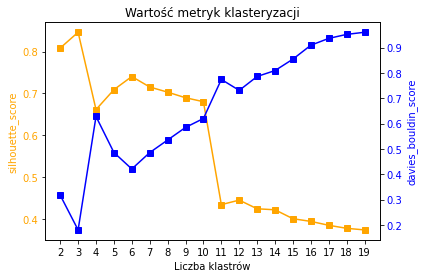

In [173]:
def two_metrics_plot(scores, clusters_range, metricname1, metricname2, x_label = 'Liczba klastrów'):
    fig, ax = plt.subplots()
    ax.plot(clusters_range, scores[0], 's-', color = 'orange')
    ax.set_ylabel(metricname1, color = 'orange')
    ax.tick_params(axis = 'y', labelcolor = 'orange')
    ax.set_xlabel(x_label)
    ax2 = ax.twinx()
    ax2.plot(clusters_range, scores[1], 's-', color = 'blue')
    ax2.set_ylabel(metricname2, color = 'blue')
    ax2.tick_params(axis = 'y', labelcolor = 'blue')
    plt.xticks(clusters_range)
    plt.title('Wartość metryk klasteryzacji')

scores = [[] for _ in range(2)]
for k in range(2, 20):
    model = KMeans(n_clusters = k)
    labels = model.fit_predict(data)
    scores[0].append(silhouette_score(data, labels))
    scores[1].append(davies_bouldin_score(data, labels))

two_metrics_plot(scores, range(2, 20), 'silhouette_score', 'davies_bouldin_score')

Mając na uwadze, że pragniemy zmaksymalizować wartość Silhouette i zminimalizować indeks Davies-Bouldina, najlepszą liczbą klastrów okazała się 3.

In [145]:
def model_scatter_3d(data, model, **kwargs):
    Model = model(**kwargs)
    labels = Model.fit_predict(data)
    fig = go.Figure(data = [go.Scatter3d(x = data.iloc[:,0], y = data.iloc[:,1], z = data.iloc[:,2],
                              mode = 'markers', marker = dict(size = 1.5, color = labels))])
    n_cluster = len(np.unique(labels))
    to_title = '.'
    if -1 in labels:
        n_cluster-=1
        to_title += " Wystąpiły 'szumy'."
    fig.update_layout(title = model.__name__ + ', liczba klastrów: ' + str(n_cluster) + to_title)
    return fig


In [146]:
model_scatter_3d(data, KMeans, n_clusters = 3, random_state = 10)

Niestety ku mojemu zawodowi, algorytm KMeans nie podzielił największej grupy obserwacji. Sprawdźmy zatem również jak spisze się metoda dla 4 klastrów:

In [166]:
model_scatter_3d(data, KMeans, n_clusters = 4, random_state = 10)

KMeans podzielił dane w zaskakujący mnie sposób - wzdłuż osi $x$ prezentowanego wykresu, zamiast osi $y$.

# DBSCAN - drugi sprawdzany algorytm klasteryzujący

Korzystając z DBSCAN kluczowym jest ustalenie dwóch parametrów: eps - maksymalna odległość między dwoma obserwacjami, aby było rozważane ich sąsiedztwo oraz min_samples - minimalna liczba obserwacji w sąsiedztwie aby punkt był traktowany jako centrum. Korzystając z informacji zawartych w artykule [Jörg Sander, Martin Ester, Hans-Peter Kriegel, and Xiaowei Xu. 1998. Density-based clustering in spatial databases: The algorithm GDBSCAN and its applications. Data Mining and Knowledge Discovery2, 2 (1998), 169–194.](http://dx.doi.org/10.1023/A:100974521941) (artykuł płatny - cytowanie za [Schubert, Erich & Sander, Jörg & Ester, Martin & Kriegel, Hans & Xu, Xiaowei. (2017). DBSCAN revisited, revisited: Why and how you should (still) use DBSCAN. ](https://dl.acm.org/doi/pdf/10.1145/3068335) ) zdecydowałem się na zastosowanie arbitralnego sposobu ustawienia tych parametrów:
- min_samples = $2 *$ `wymiar danych`
- eps = odległość, względem której większość spośród $k$-tych sąsiadów dla poszczególnych obserwacji jest bliżej. $k$ jest obliczane przy pomocy formuły $2 * $ `wymiar danych` $- 1$

Ponadto, niektóre obserwacje mogą być traktowane jako wartości odstające - w takim przypadku zostanie wystosowany odpowiedni komunikat.

In [131]:
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(euclidean(X.loc[i,:], X.loc[j,:]))
        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])
    return kn_distance
distances = calculate_kn_distance(data, 5)

KeyboardInterrupt: 

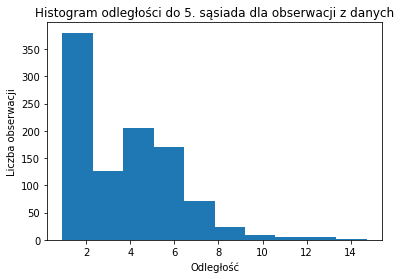

In [167]:
plt.hist(distances)
plt.ylabel('Liczba obserwacji')
plt.xlabel('Odległość')
plt.title('Histogram odległości do 5. sąsiada dla obserwacji z danych')
plt.show()

Poszukiwaną wartością jest jedna z 8-14.

In [172]:
model_scatter_3d(data, DBSCAN, eps = 14,min_samples = 6)

In [169]:
model_scatter_3d(data, DBSCAN, eps = 12, min_samples = 6)

In [170]:
model_scatter_3d(data, DBSCAN, eps = 10, min_samples = 6)

Dla $eps = 10$ algorytm DBSCAN ocenił, że niektóre wartości są odstające - zostały one oznaczone na bordowo. Niemniej na powyższych ilustracjach metody podziału nie różnią się znacząco. Sprawdźmy zatem jak prezentują się wartości metryk dla poszczególnych wartości $eps$.

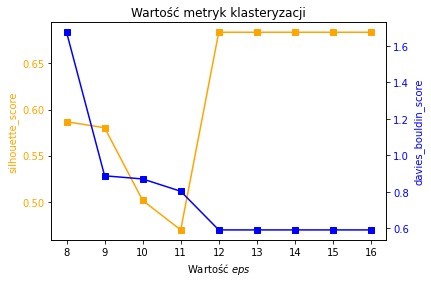

In [175]:
scores = [[] for _ in range(2)]
for k in range(8, 17):
    model = DBSCAN(eps = k, min_samples=6)
    labels = model.fit_predict(data)
    scores[0].append(silhouette_score(data, labels))
    scores[1].append(davies_bouldin_score(data, labels))

two_metrics_plot(scores, range(8, 17), 'silhouette_score', 'davies_bouldin_score', 'Wartość $eps$')

Przez autorów ww. artykułów zostało wskazane, że wartość parametru powinna być możliwie najniższa, wobec czego w przypadku poszukiwań w zbiorze liczb całkowitych, najlepszą wartością parametru jest 12. Podział jest prezentowany na przedostatnim wykresie trójwymiarowym.